# Detección de QRS



Monto el drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importo librerías que voy a utilizar:

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.signal as sp
import pandas as pd


**PhysioNet** es un repositorio de datos de investigación médica de libre acceso administrado por el Laboratorio de Fisiología Computacional del MIT y cuenta con el apoyo del Instituto Nacional de Imágenes Biomédicas y Bioingeniería (NIBIB). Cuenta con un archivo enorme y en crecimiento de registros digitales bien caracterizadss de señales fisiológicas y datos relacionados para uso de la comunidad de investigación biomédica. Incluye bases de datos de señales multiparamétricas cardiopulmonares, neurales, musculares y cognitivas de sujetos sanos y pacientes con una variedad de afecciones con implicaciones importantes para la salud pública, que incluyen muerte cardíaca súbita, insuficiencia cardíaca congestiva, epilepsia, trastornos de la marcha, apnea del sueño y envejecimiento.


In [3]:
# Instalo librerias utiles

! pip install wfdb # https://github.com/MIT-LCP/wfdb-python
# https://wfdb.readthedocs.io/en/latest/

import wfdb 



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Librerías en internet:  [wfdb](https://wfdb.readthedocs.io/en/latest/index.html)

En Python, existe la librería wfdb que está compuesta de herramientas para leer, escribir y procesar señales y anotaciones del tipo WFDB. Su principal objetivo fue poder implementar tantas de sus funciones principales como sea posible, con API fáciles de usar. Con el tiempo, se fueron agregando herramientas adicionales útiles de procesamiento de señales fisiológicas.
Nosotros, vamos a utilizar varias funciones dentro de este paquete. Para la librería completa [aquí](https://wfdb.readthedocs.io/en/stable/).

## Leo señales de Physionet


Fuente: https://physionet.org/content/mitdb/1.0.0/


> Cargo archivo 109 de Mitdb

In [4]:
path = '/content/drive/MyDrive/SIM2022Q2/señales/mitdb/109'
N = 20000
signal, fields = wfdb.io.rdsamp(path, 0, N)


In [5]:
# CHEQUEAMOS FIELDS
print(type(fields))
print(fields['fs'], fields['sig_name'])
print(fields.keys())


<class 'dict'>
360 ['MLII', 'V1']
dict_keys(['fs', 'sig_len', 'n_sig', 'base_date', 'base_time', 'units', 'sig_name', 'comments'])


> Graficamos la señal

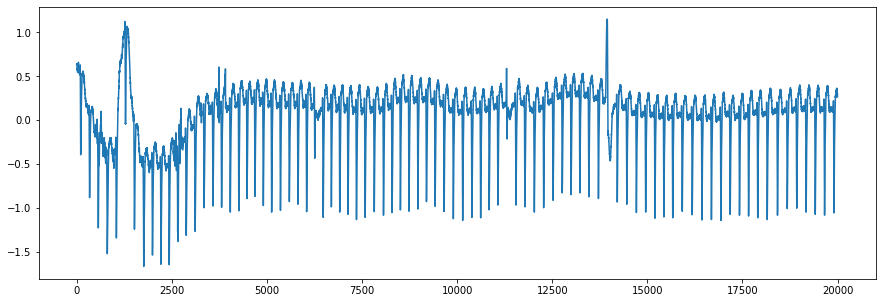

In [6]:
fs = fields['fs']
t = np.linspace(0,N/fs,N)
plt.figure(figsize=(15,5))
plt.plot(signal[:,1])

## Utilizo las anotaciones de la base de datos como gold standard para medir la performance de nuestro detector

> Leo anotaciones del registro 109

In [7]:
# Leo anotaciones
ann = wfdb.io.rdann(path, 'atr', sampfrom=0, sampto=N, return_label_elements=['symbol', 'description'])
wfdb.io.show_ann_labels()


    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

> Detecto etiquetas de latidos anormales y los marco en la gráfica del registro de ECG

(array([   18,   111,   343,   571,   807,  1048,  1287,  1523,  1765,
        1994,  2219,  2435,  2661,  2883,  3116,  3352,  3586,  3813,
        4041,  4264,  4480,  4690,  4908,  5128,  5358,  5592,  5820,
        6047,  6259,  6482,  6696,  6918,  7134,  7357,  7584,  7824,
        8067,  8292,  8512,  8737,  8971,  9197,  9423,  9660,  9902,
       10148, 10391, 10620, 10845, 11075]), ['+', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'F', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L'])
[(18, '+'), (6259, 'F'), (11310, 'F'), (13924, 'V')]


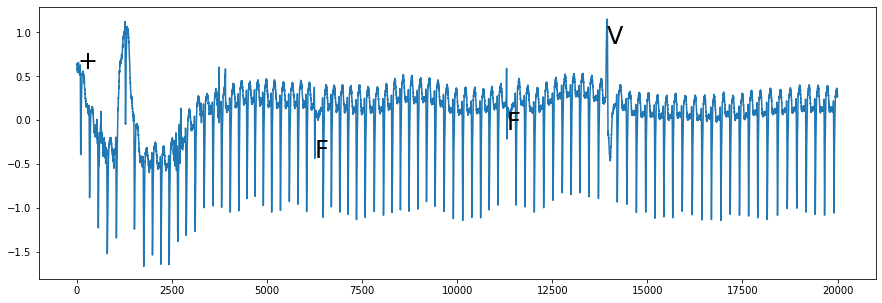

In [8]:
anormales = []
print((ann.sample[:50], ann.symbol[:50]))
for (samplee, label) in zip(ann.sample, ann.symbol):
  if label != 'L':
    anormales.append((samplee, label))

print(anormales)

plt.figure(figsize=(15,5))
plt.plot(signal[:,1])
for (sample, label) in anormales:
  # plt.plot(sample/fs, x[sample], '*k')
  plt.text(sample, signal[sample,1], label, fontsize=24)

> Muestro los tipos de anotaciones

In [9]:
# muestra las etiquetas estándar


## Implemento Pan y Tompkins

In [10]:
#  Pan-Tompkins:
# ECG -> passband filter -> Derivative Filter -> Squaring -> Moving window integration

from scipy.signal import butter, sosfiltfilt, lfilter

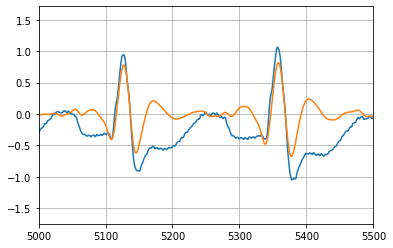

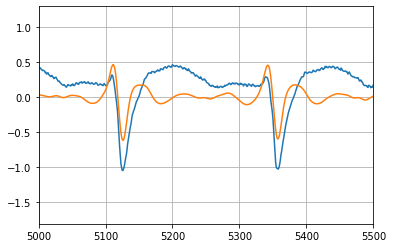

In [11]:
# Bandpass filter 5-20Hz
fs = fields['fs']
Ts = 1/fs
low_cut = 5
high_cut = 20

# # Normalizing with sampling frequency
# low = low_cut*2/fs
# high = high_cut*2/fs

# # Hamming filtered coefficients using Matlab filter design
# num = [0.007645458749198928531665142571682736161,
# 0.02292637235579575785693329237346915761, 
# 0.068444356472501508004135928331379545853,
# 0.136003874076081554544970231290790252388,
# 0.197594678513626609284159485468990169466,
# 0.222520214609595839982958409564162138849,
# 0.197594678513626609284159485468990169466,
# 0.136003874076081554544970231290790252388,
# 0.068444356472501508004135928331379545853,
# 0.02292637235579575785693329237346915761, 
# 0.007645458749198928531665142571682736161]
# den = [1]
# filtered_signal = sp.lfilter(num,den,signal)

signal1 = signal[:,0]
signal2 = signal[:,1]

sos = butter(5, [5, 25], 'band', fs=fs, output='sos')
filtered_signal1 = sosfiltfilt(sos, signal1)
filtered_signal2 = sosfiltfilt(sos, signal2)

filtered_signal1_normalized = filtered_signal1/np.max(np.abs(filtered_signal1))
filtered_signal2_normalized = filtered_signal2/np.max(np.abs(filtered_signal2))


N = 20000
N_vector = np.arange(0,N)
t = np.linspace(0,N/fs,N)

plt.figure(1)
plt.plot(N_vector,signal1)
plt.plot(N_vector,filtered_signal1)
plt.xlim((5000,5500))
plt.grid()
# plt.xlabel('Samples')
# plt.title('Raw signal')

plt.figure(2)
plt.plot(N_vector,signal2)
plt.plot(N_vector,filtered_signal2)
plt.xlim((5000,5500))
plt.grid()
# plt.xlabel('Samples')
# plt.title('Filtered signal')

# plt.figure(3)
# plt.plot(N_vector,filtered_signal_normalized)
# plt.xlim((5000,5500))
# plt.grid()
# plt.xlabel('Samples')
# plt.title('Normalized filtered signal')

# plt.figure(4)
# w,h = sp.freqz(num,den)
# f = fs * w / (2*np.pi)
# plt.plot(f, 20 * np.log10(abs(h)), label="Hamming window")
# plt.grid()
# plt.title('Filter bode')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Gain')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, 'Gain')

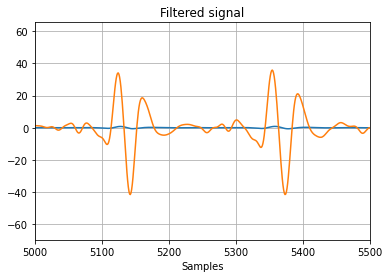

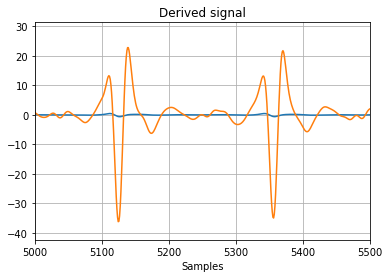

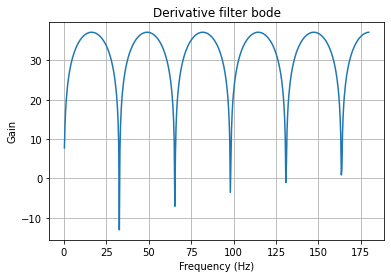

In [12]:
# Derivative filter provides QRS slope information
L = 10
L_array = np.zeros(L) # Amount of zeros
num_derivative = np.array([1])
num_derivative = np.append(num_derivative,L_array)  # Skip factor
num_derivative = np.append(num_derivative,-1) / (L*Ts)
den_derivative = [1]

derived_signal1 = sp.lfilter(num_derivative,den_derivative,filtered_signal1)

derived_signal1_normalized = derived_signal1/np.max(np.abs(derived_signal1))


derived_signal2 = sp.lfilter(num_derivative,den_derivative,filtered_signal2)

derived_signal2_normalized = derived_signal2/np.max(np.abs(derived_signal2))


plt.figure(1)
plt.plot(N_vector, filtered_signal1)
plt.plot(N_vector,derived_signal1)
plt.xlim((5000,5500))
plt.grid()
plt.xlabel('Samples')
plt.title('Filtered signal')

plt.figure(2)
plt.plot(N_vector, filtered_signal2)
plt.plot(N_vector,derived_signal2)
plt.xlim((5000,5500))
plt.grid()
plt.xlabel('Samples')
plt.title('Derived signal')

# plt.figure(3)
# plt.plot(N_vector,derived_signal_normalized)
# plt.xlim((5000,5500))
# plt.grid()
# plt.xlabel('Samples')
# plt.title('Normalized derived signal')

plt.figure(4)
w_derivative,h_derivative = sp.freqz(num_derivative,den_derivative)
f = fs * w_derivative / (2*np.pi)
plt.plot(f, 20 * np.log10(abs(h_derivative)), label="Hamming window")
plt.grid()
plt.title('Derivative filter bode')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')

Text(0.5, 1.0, 'Normalized derived signal')

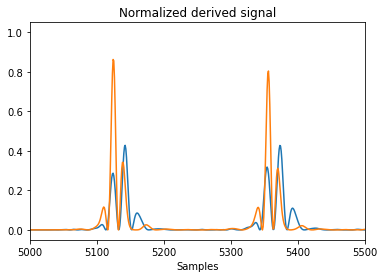

In [13]:
# Squaring intensifies values received in derivative
squared_signal1 = derived_signal1_normalized**2
squared_signal2 = derived_signal2_normalized**2

plt.figure(1)
plt.plot(N_vector,squared_signal1)
plt.xlim((5000,5500))
plt.grid()
plt.xlabel('Samples')
plt.title('Normalized derived signal')

plt.figure(1)
plt.plot(N_vector,squared_signal2)
plt.xlim((5000,5500))
plt.grid()
plt.xlabel('Samples')
plt.title('Normalized derived signal')

In [14]:
# Moving window integration
# window_size = 100e-3*fs  # 100ms QRS durability
# tolerance = 8e-3*fs  # 8ms tolerance
# window_size = round(window_size + tolerance)
# integration_window = np.ones(window_size)/round(window_size)
# integrated_signal = np.convolve(squared_signal,integration_window)

# n = np.size(integrated_signal)
# N_vec = np.arange(0,n)

# plt.figure(1)
# plt.plot(N_vec,integrated_signal)
# plt.xlim((5000,5500))
# plt.grid()
# plt.xlabel('Samples')
# plt.title('Integrated signal')

In [15]:
# Moving window integration
def moving_integration(signal, fs):
  samples = round(0.1*fs)
  b = np.ones(samples)
  b = b/0.2
  moving_int = np.roll(lfilter(b,1,signal),-samples//2)
  return moving_int

Text(0.5, 1.0, 'Integrated signal')

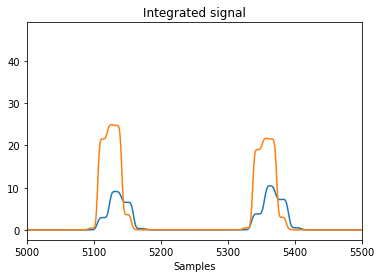

In [16]:
moving_int_signal1 = moving_integration(squared_signal1**2,fs)
moving_int_signal2 = moving_integration(squared_signal2**2,fs)

n1 = np.size(moving_int_signal1)
N_vec1 = np.arange(0,n1)

n2 = np.size(moving_int_signal2)
N_vec2 = np.arange(0,n2)

plt.figure(1)
plt.plot(N_vec1,moving_int_signal1)
plt.xlim((5000,5500))
plt.grid()
plt.xlabel('Samples')
plt.title('Integrated signal')

plt.figure(1)
plt.plot(N_vec2,moving_int_signal2)
plt.xlim((5000,5500))
plt.grid()
plt.xlabel('Samples')
plt.title('Integrated signal')

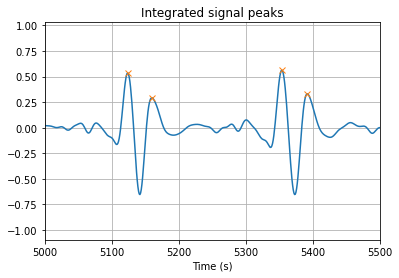

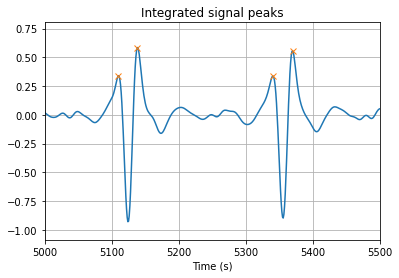

In [17]:
# Peak detection 
# threshold = 3.5e-3  # Maximum amplitude QRS
threshold = 0.20
peaks1, peaks1_properties = sp.find_peaks(derived_signal1_normalized,threshold)
peaks2, peaks2_properties = sp.find_peaks(derived_signal2_normalized,threshold)

plt.figure(1)
plt.plot(N_vector,derived_signal1_normalized)
plt.plot(peaks1,derived_signal1_normalized[peaks1],'x')
plt.xlim((5000,5500))
plt.grid()
plt.xlabel('Time (s)')
plt.title('Integrated signal peaks')
plt.show()

plt.figure(1)
plt.plot(N_vector,derived_signal2_normalized)
plt.plot(peaks2,derived_signal2_normalized[peaks2],'x')
plt.xlim((5000,5500))
plt.grid()
plt.xlabel('Time (s)')
plt.title('Integrated signal peaks')
plt.show()

In [18]:
# # Stage graphs

# # Bandpass filter 5-20Hz
# plt.figure(1)
# plt.plot(t,signal)
# plt.xlim((13,15))
# plt.grid()
# plt.xlabel('Time (s)')
# plt.title('Raw signal')

# # Derivative Filter
# plt.figure(2)
# plt.plot(t,filtered_signal_normalized)
# plt.xlim((13,15))
# plt.grid()
# plt.xlabel('Time (s)')
# plt.title('Normalized filtered signal')

# # Squaring
# plt.figure(3)
# plt.plot(t,derived_signal1_normalized)
# plt.xlim((13,15))
# plt.grid()
# plt.xlabel('Time (s)')
# plt.title('Normalized derived signal')

# # Moving window integration
# # plt.figure(4)
# # plt.plot(t,integrated_signal)
# # plt.xlim((13,15))
# # plt.grid()
# # plt.xlabel('Time (s)')
# # plt.title('Integrated signal')

# # Peaks detection 
# plt.figure(5)
# plt.plot(N_vector,derived_signal1_normalized)
# plt.plot(peaks,derived_signal1_normalized[peaks],'x')
# plt.xlim((5000,5500))
# plt.grid()
# plt.xlabel('Time (s)')
# plt.title('Integrated signal peaks')

## Mido sensibilidad y VPP del detector implementado

La **Sensibilidad** indica la capacidad de nuestro estimador para dar como casos positivos los casos realmente enfermos. Es la proporción de enfermos correctamente identificados. Es decir, la sensibilidad caracteriza la capacidad de la prueba para detectar la enfermedad en sujetos enfermos.

$Sens = \frac{VP}{VP + FN}$

Mientras que la **Especificidad** nos indica la capacidad de nuestro estimador para dar como casos negativos los casos realmente sanos. Esto es, la proporción de sanos correctamente identificados. Es decir, la especificidad caracteriza la capacidad de la prueba para detectar la ausencia de la enfermedad en sujetos sanos.

$Espec = \frac{VN}{VN + FP}$





## Cuidado!!

En un detector de complejos QRS, existe un VP pero no un VN. Por eso usamos el Valor Predictivo Positivo (VP+) en lugar de la Especificidad.
El VP+ mide la eficacia real de una prueba diagnóstica. Define la probabilidad de que dada una detección (+/-), el sujeto esté realmente en esa condición (enfermo/no enfermo). Depende de la prevalencia de una enfermedad.

$VP+ = \frac{VP}{FP + VP}$




## En términos estadísticos, según el Teorema de Bayes

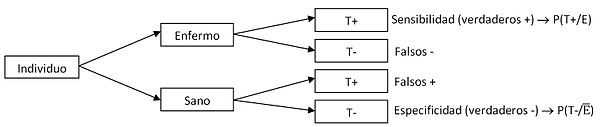

$VP+ = P(E/T+) = \frac{P(E \cap T+)} {P(E \cap T+)+P(\overline{E} \cap T+)} = \frac{P(E)P(T+/E)} {P(E)P(T+/E)+P(\overline{E})P(T+/\overline{E})} = \frac{P*Sens} {P*Sens + (1-P)*(1-Espec)}$

Donde P es la prevalencia de la enfermedad.

In [19]:
def analisis_estadistico(estimacion, patron,umbral):
  vp = 0
  fn = 0
  fp = 0
  for i in np.arange(len(patron)):
    for j in np.arange(len(estimacion)):
      if np.abs(patron[i] - estimacion[j]) < umbral:
        vp = vp + 1
        flag_fn = 1
        break
    if flag_fn == 0:
      fn = fn + 1
    flag_fn = 0
  fp = len(estimacion)-vp
  return vp, fn, fp



In [20]:
vp_0, fn_0, fp_0 = analisis_estadistico(peaks1, ann.sample[1:], 0.4*fs)
print('Señal 0\n')
print('vp = ', vp_0,' | fn = ', fn_0,' | fp = ', fp_0)
print('\nSens = ', vp_0/(vp_0+fn_0),' | VP+ = ', vp_0/(vp_0+fp_0))

Señal 0

vp =  85  | fn =  0  | fp =  83

Sens =  1.0  | VP+ =  0.5059523809523809


In [21]:
vp_1, fn_1, fp_1 = analisis_estadistico(peaks2, ann.sample[1:], 0.2*fs)
print('Señal 1\n')
print('vp = ', vp_1,' | fn = ', fn_1,' | fp = ', fp_1)
print('\nSens = ', vp_1/(vp_1+fn_1),' | VP+ = ', vp_1/(vp_1+fp_1))

Señal 1

vp =  85  | fn =  0  | fp =  86

Sens =  1.0  | VP+ =  0.49707602339181284


Resolver, hay demasiados falsos positivos, error en detección (error en filtro derivativo)